# Exercise List 6 - Radiative Processes

Luana Passos Reis

In [1]:
## Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
from astropy import constants as const
from scipy.stats import chisquare
from scipy.optimize import curve_fit

## Exercise 1')
### Synchrotron emission from the halo of the Galaxy.

In this exercise, we are considering a simplified model of the Galaxy's magnetic field ($B_{phi}$), which consists only of an azimuthal component (toroidal).

But first, we need to deal with the galactic coordinates, that approximate a coordinate system centered on the location of the Sun, in which

- l_long : galactic longitude
(angular distance measured along the galactic plane, ranging from 0º to 360º to the east)

- b_lat : galactic latitude
(angular distance measured perpendicularly to the galactic plane, ranging from 0º to 90º to the north and from 0º to -90º to the south)

In [2]:
## Constants

c = const.c.value           # velocity of light
e = const.e.value           # electron charge
m_e = const.m_e.value       # electron mass


## Parameters given by the exercise

# ----- Galactocentric Cartesian Coordinates -----
x_e = - 8.5 #* u.kpc
y_e = 0 #* u.kpc
z_e = 0 #* u.kpc

r_e = 8.5 #* u.kpc

# ----- z > 0 -----
B_n = 1.4 #* u.uG      # uG = microGauss
r_n = 9.22 #* u.kpc

# ----- z < 0 -----
B_s = -1.1 #* u.uG
r_s = 17.7 #*u.kpc

# -----  -----
z_0 = 5.3 #* u.kpc
w_h = 0.20 #* u.kpc
p = 3
n_0 = 4e-5 #* u.cm**(-3)
h_r = 5 #* u.kpc
h_z = 1 #* u.kpc
nu = (22 * u.GHz).to('Hz').value

In [3]:
## Functions

# --------------- Handling the Coordinate System ---------------
def coord_galac(s_radius, l_long, b_lat):
    '''
    We want to estimate the x, y and z, given the latitude and longitude of the system.
    
    '''
    
    theta = np.abs( np.deg2rad(b_lat) - np.pi / 2 )
    phi = np.deg2rad(l_long)
    
    x = ( s_radius * np.sin(theta) * np.cos(phi) ) - x_e
    y = ( s_radius * np.sin(theta) * np.sin(phi) ) - y_e
    z = ( s_radius * np.cos(theta) ) - z_e

    r = np.sqrt(x**2 + y**2)
    
    return x, y, z, r




# --------------- Magnetic Field Component ---------------
def mag_field(s_radius, l_long, b_lat):
    '''
    B_phi is the magnetic field on the azimutal component of an AGN (toroidal), and B_modulus
    is the parallel part that we are insterest in this case.
    
    '''
    theta = np.abs( np.deg2rad(b_lat) - np.pi / 2 )
    phi = np.deg2rad(l_long)
    
    x_g, y_g, z_g, r_g = coord_galac(s_radius, l_long, b_lat)
    
    if (z_g > 0):
        B_alpha = B_n
        r_alpha = r_n
    else:
        B_alpha = B_s
        r_alpha = r_s

    B_phi = B_alpha * np.exp( - np.abs(z_g) / z_0 ) * ( 1 - ( 1 / ( 1 + np.exp( - 2 * ( np.abs(r_g) - r_alpha ) / w_h ) ) ) )

    phi_g = np.arctan2(y_g, x_g)
    
    B_vector = B_phi * np.array([ - np.sin(phi_g), np.cos(phi_g), 0 ])
    r_vector = s_radius * np.array([np.sin(theta)* np.cos(phi) - x_e/s_radius, np.sin(theta) * np.sin(phi), np.cos(theta)])
    
    r_modulus = np.linalg.norm(r_vector)
    r_versor = r_vector / r_modulus

    B_perp = B_vector - r_versor * np.dot(B_vector, r_versor)
    B_modulus = np.linalg.norm(B_perp)
    
    return B_modulus




# --------------- Electron CR Distribution ---------------
def electron_CR_dist(r, z, gamma):
    '''
    n_cre is the cosmic ray distribution of electrons in the galaxy.
    
    '''
    n_cre = n_0 * ( (np.exp( -r / h_r )) / (np.cosh( z / h_z ))**2 ) * ( (np.cosh( z_e / h_z ))**2 / ( np.exp( -r_e / h_r ) ) * gamma**(-p) )
    
    return n_cre

The simplified model of the magnetic field of the Galaxy we are considering:

In [4]:
n = 1000

angle_l_long = np.linspace(-180, 180, n)
angle_b_lat = np.linspace(-90, 90, n)

# angle_l_long = np.linspace(-179, 179, n)
# angle_b_lat = np.linspace(-89, 89, n)


B = np.zeros([len(angle_l_long), len(angle_b_lat)])
list_l,list_b = np.zeros(n*n), np.zeros(n*n)

count = 0
for i in range(0,len(angle_b_lat),1):
    for j in range(0,len(angle_l_long),1):
        B[i,j] = mag_field(r_e, angle_l_long[j], angle_b_lat[i])
        
        list_b[count] = angle_b_lat[i]
        list_l[count] = angle_l_long[j]
        count += 1

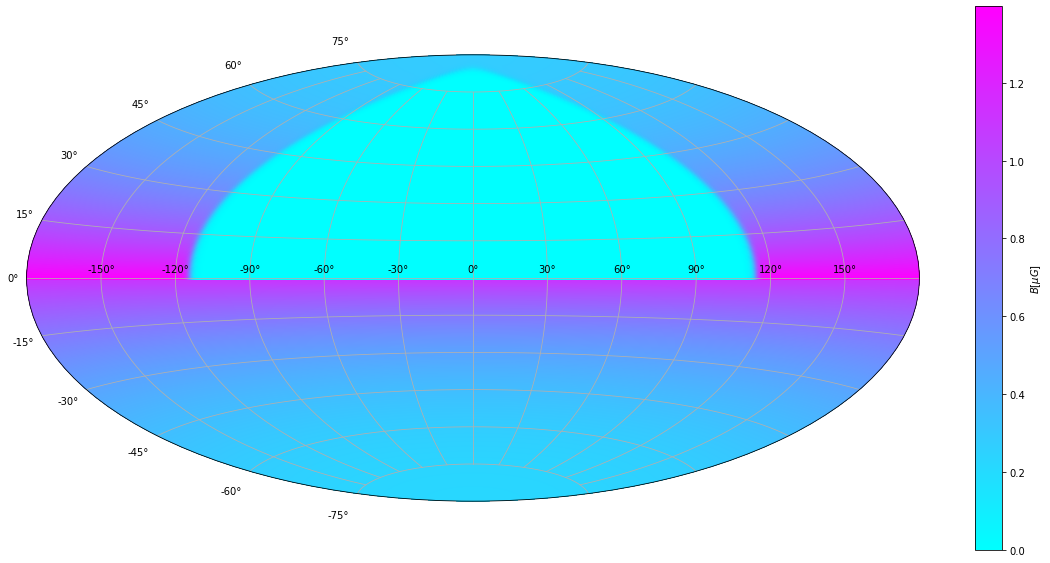

In [5]:
lv,bv = np.meshgrid(angle_l_long, angle_b_lat)
bv,lv = bv.reshape(n*n) * np.pi/180, lv.reshape(n*n) * np.pi/180

plt.figure(figsize=(20, 10))

plt.subplot(111, projection='aitoff')
plt.scatter(lv, bv, c = B, cmap = 'cool', marker = '.')

plt.colorbar(location='right', label=r'$B [\mu G]$')

plt.grid(True)
plt.show()

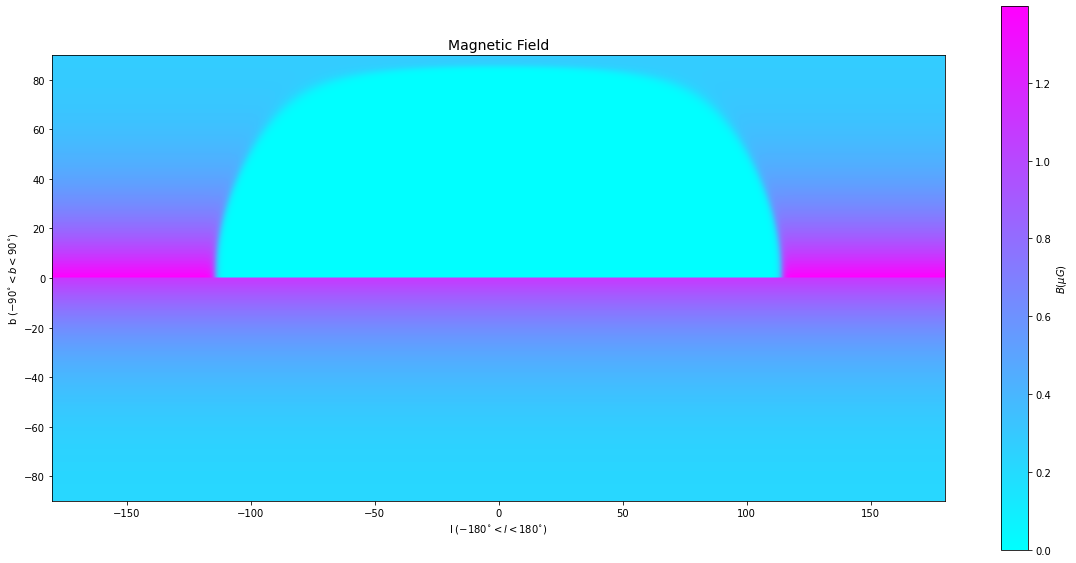

In [6]:
plt.figure(figsize=(20, 10))

plt.imshow(B, extent=[angle_l_long[0], angle_l_long[len(angle_l_long)-1], angle_b_lat[0], angle_b_lat[len(angle_b_lat)-1]], cmap = 'cool', origin='lower')

plt.title(r'Magnetic Field', fontsize = 14)

plt.xlabel(r'l ($-180^{\circ} < l < 180^{\circ}$)')
plt.ylabel(r'b ($-90^{\circ} < b < 90^{\circ}$)')

plt.colorbar(location='right',label=r'$B (\mu G)$')

plt.show()

### A)

Let's estimate the Synchrotron Intensity I (in mK).

In [7]:
import math
import scipy.integrate as integrate

# --------------- Synchrotron Intensity ---------------
def synch_intensity(s_radius, l_long, b_lat):
    '''
    I_nu is the synchrotron intensity for a given position (r, z) in the galaxy.
    
    '''
    x_g, y_g, z_g, r_g = coord_galac(s_radius, l_long, b_lat)

    
    CR_dist = electron_CR_dist(r_g, z_g, math.gamma(3/4 + 19/12))
    B_modulus = mag_field(s_radius, l_long, b_lat)

    P = ((3 * np.sqrt(3) * e**4 * CR_dist * B_modulus**2)/(16 * np.pi**2 * m_e**2 * c**3 * nu)) * math.gamma(3/4 + 19/12) * math.gamma(3/4 - 1/12)    # erg/cm^3

    I_nu = P / (4 * np.pi)
    
    return I_nu




# --------------- Distance ---------------
def distancias_g(s_radius, l_long, b_lat):

    x, y, z, r = coord_galac(s_radius, l_long, b_lat)

    return np.sqrt((x+2*8.5)**2 + y**2 + z**2)

In [8]:
n2 = 300
angle_l2 = np.linspace(-180, 180, n2)    # in degree
angle_b2 = np.linspace(-90, 90, n2)      # in degree

M_I = np.zeros([len(angle_b2),len(angle_l2)])

for i in range(len(angle_b2)):
    b = angle_b2[i]
    for j in range(len(angle_l2)):
        l = angle_l2[j]

        dist_max = distancias_g(15, l, b) #diametro da galaxia = 30 kpc
        s = np.arange(0.2,dist_max,0.5)

        jotas = np.zeros(len(s))
        for k in range(0,len(s),1):

            jotas[k] = synch_intensity(s[k], l, b) #in erg * kpc / cm^3 

        M_I[i][j] = integrate.simps(jotas[:], s[:]) * 3.086e21

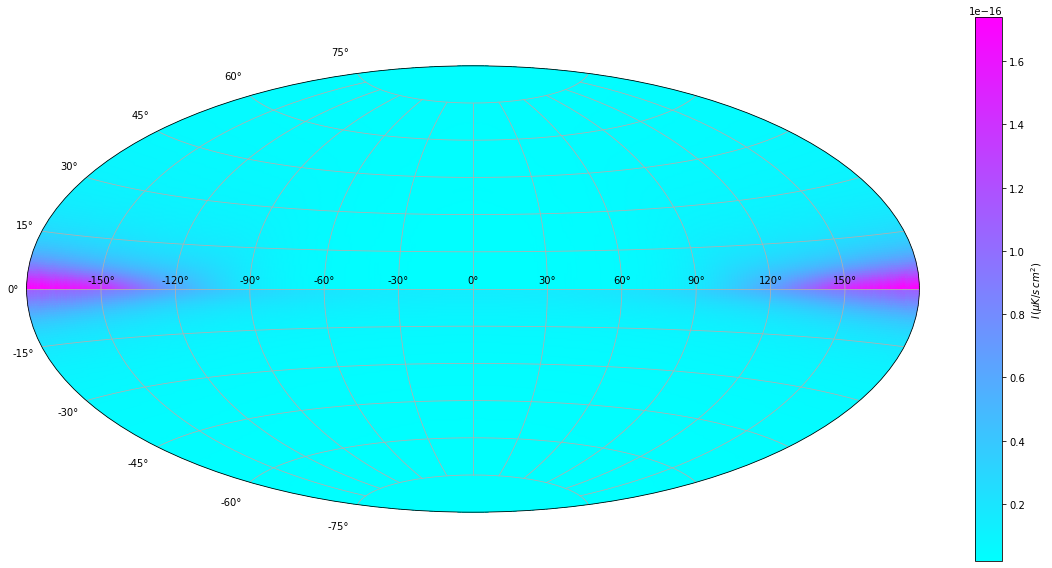

In [9]:
lv2,bv2 = np.meshgrid(angle_l2, angle_b2)

bv2,lv2 = bv2.reshape(n2*n2)*np.pi/180, lv2.reshape(n2*n2)*np.pi/180


plt.figure(figsize=(20, 10))

plt.subplot(111,projection='aitoff')

plt.scatter(lv2, bv2, c = M_I/1.38064878066852e-19, cmap='cool', marker='.')
plt.colorbar(location='right', label=r'$I \, (\mu K /s \hspace{0.2} cm^2)$')

plt.grid(True)
plt.show()

### B)

Let's estimate the Stokes Parameters Q and U (in mK).

In [10]:
# --------------- Stokes Parameters ---------------
def stokes_param(s_radius, l_long, b_lat):
    '''
    To calculate the Stokes Parameters.
    
    '''
    
    ## Same as mag_field function
    
    theta = np.abs( np.deg2rad(b_lat) - np.pi / 2 )
    phi = np.deg2rad(l_long)
    
    x_g, y_g, z_g, r_g = coord_galac(s_radius, l_long, b_lat)
    
    if (z_g > 0):
        B_alpha = B_n
        r_alpha = r_n
    else:
        B_alpha = B_s
        r_alpha = r_s

    B_phi = B_alpha * np.exp( - np.abs(z_g) / z_0 ) * ( 1 - ( 1 / ( 1 + np.exp( - 2 * ( np.abs(r_g) - r_alpha ) / w_h ) ) ) )

    phi_g = np.arctan2(y_g, x_g)
    
    B_vector = B_phi * np.array([ - np.sin(phi_g), np.cos(phi_g), 0 ])
    r_vector = s_radius * np.array([np.sin(theta)* np.cos(phi) - x_e/s_radius, np.sin(theta) * np.sin(phi), np.cos(theta)])
    
    r_modulus = np.linalg.norm(r_vector)
    r_versor = r_vector / r_modulus

    B_perp = B_vector - r_versor * np.dot(B_vector, r_versor)
    B_modulus = np.linalg.norm(B_perp)
    
    ## Same as synch_intensity function
    
    CR_dist = electron_CR_dist(r_g, z_g, math.gamma(3/4 + 19/12))

    P = ((3 * np.sqrt(3) * e**4 * CR_dist * B_modulus**2)/(16 * np.pi**2 * m_e**2 * c**3 * nu)) * math.gamma(3/4 + 19/12) * math.gamma(3/4 - 1/12)    # erg/cm^3

    j_tot = P / (4 * np.pi)
    
    pizao = (4/(3+7/3))
    vet_z = np.array([0, 0, 1])

    psi = np.arccos(np.dot(B_perp, vet_z))
    if np.isnan(psi):
        psi = np.pi/2
    cos_2psi = np.cos(2*psi + np.pi)
    sen_2psi = np.sin(2*psi + np.pi)
    
    Q = j_tot*pizao*cos_2psi
    U = j_tot*pizao*sen_2psi

    return Q, U

In [11]:
M_Q = np.zeros([len(angle_b2),len(angle_l2)])
M_U = np.zeros([len(angle_b2),len(angle_l2)])

for i in range(len(angle_b2)):
    b = angle_b2[i]
    for j in range(len(angle_l2)):
        l = angle_l2[j]

        dist_max = distancias_g(15, l, b) #diametro da galaxia = 30 kpc
        s = np.arange(0.2,dist_max,0.5)

        Q_sto = np.zeros(len(s))
        U_sto = np.zeros(len(s))
        for k in range(0,len(s),1):

            Q_sto[k],U_sto[k] = stokes_param(s[k], l, b) #in erg * kpc / cm^3 

        M_Q[i][j] = integrate.simps(Q_sto[:], s[:]) * 3.086e21
        M_U[i][j] = integrate.simps(U_sto[:], s[:]) * 3.086e21

In [12]:
print(M_Q)

lv2,bv2 = np.meshgrid(angle_l2, angle_b2)

bv2,lv2 = bv2.reshape(n2*n2)*np.pi/180, lv2.reshape(n2*n2)*np.pi/180

[[2.23114695e-37 2.23114695e-37 2.23114695e-37 ... 2.23114695e-37
  2.23114695e-37 2.23114695e-37]
 [2.23478678e-37 2.23478601e-37 2.23478370e-37 ... 2.23478370e-37
  2.23478601e-37 2.23478678e-37]
 [2.23876084e-37 2.23875930e-37 2.23875466e-37 ... 2.23875466e-37
  2.23875930e-37 2.23876084e-37]
 ...
 [3.62177104e-37 3.62176839e-37 3.62176044e-37 ... 3.62176044e-37
  3.62176839e-37 3.62177104e-37]
 [3.61498390e-37 3.61498258e-37 3.61497859e-37 ... 3.61497859e-37
  3.61498258e-37 3.61498390e-37]
 [3.60869886e-37 3.60869886e-37 3.60869886e-37 ... 3.60869886e-37
  3.60869886e-37 3.60869886e-37]]


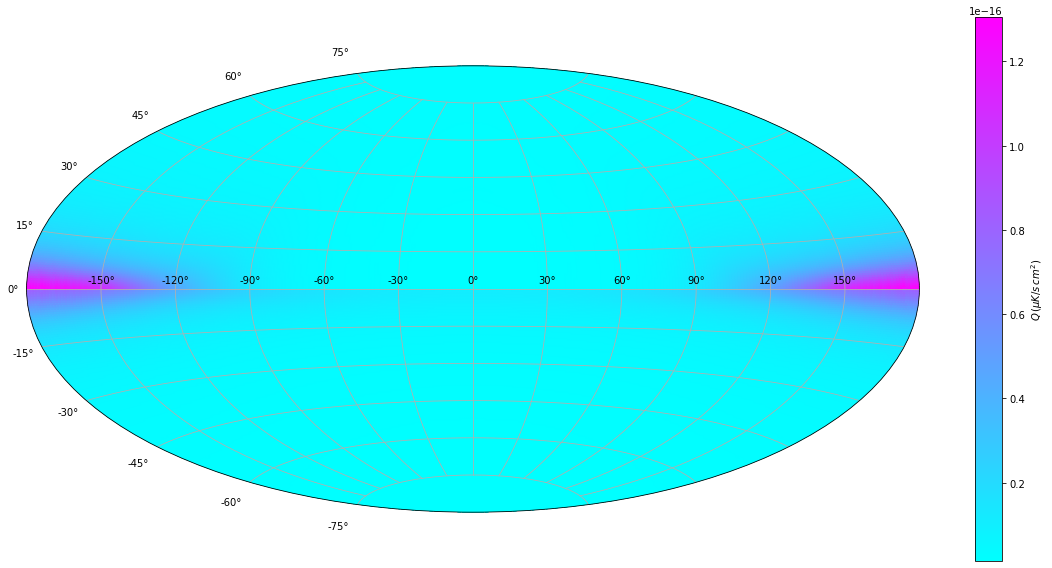

In [13]:
## Q

plt.figure(figsize=(20, 10))

plt.subplot(111,projection='aitoff')

plt.scatter(lv2, bv2, c = M_Q/1.38064878066852e-19, cmap='cool', marker='.')
plt.colorbar(location='right', label=r'$Q \, (\mu K /s \hspace{0.2} cm^2)$')

plt.grid(True)
plt.show()

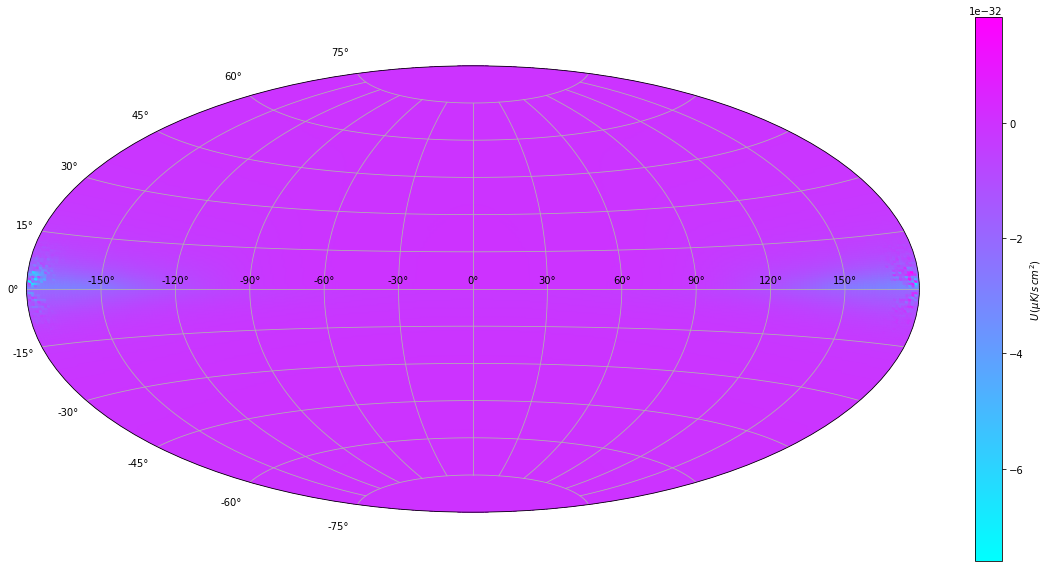

In [14]:
## U

plt.figure(figsize=(20, 10))

plt.subplot(111,projection='aitoff')

plt.scatter(lv2, bv2, c = M_U/1.38064878066852e-19, cmap='cool', marker='.')
plt.colorbar(location='right', label=r'$U \, (\mu K /s \hspace{0.2} cm^2)$')

plt.grid(True)
plt.show()